# AC-Stark assisted gate between a transmon and a fluxonium using the Ficheux-like scheme

In this notebook we study a two-qubit gate between a transmon and a fluxonium inspired by the two-qubit gate between a transmon and a fluxonium described in Ficheux et al. Phys. Rev. X 11, 021026 (2021). We also analyze how the gate can be selectively switched off using the AC-Stark effect.

In [332]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
from pysqkit.util.linalg import get_mat_elem
import pysqkit.util.transformations as trf
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit.solvers import solvkit
import qutip
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_ficheux_inspired_gate as util

from IPython.display import display, Latex

The gate is based on the following driven Hamiltonian of a fluxonium and a transmon capacitively coupled

$$H = H^{(0)}_T + H^{(0)}_F + V + H_{drive},$$

$$H^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$

$$H^{(0)}_F = 4 E_{C,F} \cdot \hat{q}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \phi_{ext,F}\right),$$

$$V = J_C \cdot \hat{q}_T \cdot \hat{q}_F,$$

$$\frac{H_{drive}}{h} = \left( \varepsilon_T \hat{q}_T + \varepsilon_F \hat{q}_F \right) \cos(2\pi f_d t).$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$

In the following we introduce relaxation due to dielectric loss and pure dephasing on each qubit as error channels. 

# Introducing the qubits and the coupled system

In [333]:
temperature = 0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=4.5, 
    anharm = -0.3,
    diel_loss_tan=0.75*1e-6, #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy*0,    
    dim_hilbert=levels_t,
    dephasing_times = {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3} 
)


# We also add a drive on the transmon now
transm.add_drive(
    pysqkit.drives.microwave_drive,
    label='transm_drive',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

#Fluxonium
levels_f = 6

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=.973, 
    induct_energy=.457, 
    joseph_energy=8.0,
    diel_loss_tan=7.1*1e-6, #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times = {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                       '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3} #ns/2*np.pi 
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

#We consider a much smaller coupling compared to the previous case without AC sta

jc = 0.07
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

In [334]:
op = coupled_sys['F'].charge_op()
ket = coupled_sys.state('01')[1]
bra =  coupled_sys.state('11')[1]
print(np.abs(get_mat_elem(op, ket, bra)))

0.017423857201680444


The basic principle behind the gate is illustrated in the following figure

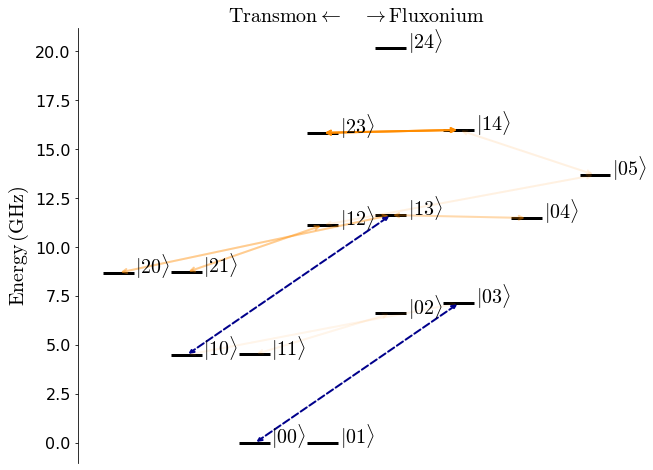

In [335]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04', '14', '23', '24', '05']

util.energy_levels_diagram(bare_system, level_list)

The figure shows the energy of the bare levels. The orange arrows indicate the non-zero matrix elements between the (bare) levels provided by the capacitive coupling $V$: the more shaded the arrow the weaker the coupling. The idea is to design the system so that the $| 1 3 \rangle$-$|0 4 \rangle$ is close to resonance so that the levels get sufficiently hybridized. A CZ gate can then be realized by driving the $|0 \rangle$-$|3 \rangle$ transition of the fluxonium, which induces transitions depicted by the blue, dashed arrow in the figure. The scheme is inspired by the one between two fluxonia described in Ficheux et al. Phys. Rev. X 11, 021026 (2021), where the $|2 1  \rangle$ and $|12 \rangle$ levels are hybridized and the transition $| 1 \rangle$-$|2 \rangle$ of one of the two fluxonia is driven.

We look at the following quantities : 

$$\zeta_{ZZ} = E_{00} + E_{11} - E_{01} - E_{10}$$
$$\Delta = \left( E_{13} - E_{10} \right) -  \left( E_{03} - E_{00} \right)$$

The $\Delta$ is similar at the one in Ficheux but looking at the 0-3 transition of the Fluxonium.

For the given parameters we have

In [336]:
display(Latex(r'$\xi_{{ZZ}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.zz(coupled_sys))))
display(Latex(r'$\Delta/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.delta(coupled_sys))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

As we see now the $\Delta$ is very small. In this case the gate would last 

In [337]:
display(Latex(r'$t_{{gate}} = {:.3f} \, \mathrm{{ns}}$'.format(1/(util.delta(coupled_sys)))))

<IPython.core.display.Latex object>

so quite a long gate time. We now show how it could be possible to shorten this by amplifying the $\Delta$ using a drive on the Transmon.

## Matching the parameters
For this case we look at the 10-13 and 00-03 transitions so we process the corresponding Rabi frequencies :

$$\Omega_{10-13}  = \left| \epsilon_T \langle 10 | \hat{n}_T | 13 \rangle + \epsilon_F \langle 10 | \hat{n}_F | 13 \rangle \right|$$
$$\Omega_{00-03}  = \left| \epsilon_T \langle 00 | \hat{n}_T | 03 \rangle + \epsilon_F \langle 00 | \hat{n}_F | 03 \rangle \right|$$

And then :
$$r = \dfrac{\Omega_{10-13}}{\Omega_{00-03}} \text{  and  } \dfrac{\delta}{\Delta} = \dfrac{r^2 - \sqrt{(r^2-1)^2 + r^2 }} {r^2 - 1}$$ 

With these conventions taken in the paper :
$$\Delta = f_{10-13} - f_{00-03}$$
$$\delta = f_{10-13} - f_d$$.

The above $\Delta$ parameter is purely set by the static Hamiltonians. It is easy to show that if we now drive the transmon qubit off-resonantly with frequency $\lvert| \omega_{d, T}$ and amplitude 
$$\Omega_T = \varepsilon_T \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4}$$

this amplifies the energy difference between the $10-13$ and the $00-03$ transition. This can be shown by simply solving the single-qubit Rabi problem for the two transitions separately in the case $\lvert (\Omega_T)/(\omega_{d, T} - \omega_T) \ll 1$ and taking the difference of the shifted transitions. In particular one finds using a simple two-level model for the two transitions, i.e., neglecting higher levels of the transmons

$$
\Delta_{Stark} \approx \Delta + \frac{\Omega_T^2}{2} \biggl(\frac{1}{\omega_T + \Delta - \omega_{d, T}} - \frac{1}{\omega_T - \omega_{d, T}} \biggr) \approx \Delta \biggl( 1 + \frac{\Omega_T^2}{2 (\omega_T - \omega_{d, T})^2} \biggr).
$$

These conventions are taken in order to have : $\Omega = \sqrt{\Omega_{10-13}^2  + \delta^2} = \sqrt{\Omega_{00-03}^2  + (\delta - \Delta)^2}$

The $\Delta$ is fixed by the parameters of the qubits, we now need to settle the values for the drive parameters.

First we need to fix the $\varepsilon$.

We take the condition of the paper :
$$\Omega = \Delta$$

However, one equation for two parameters is not enough. We assume that the fluxonium is driven much more than the transmon (as we are mainly looking at the 0-3 transtion of F) and, in general, we could take the drive on the transmon to be a fixed fraction of the one on the fluxonium. In what follows we simply set the drive on the transmon to be zero. Now we have enough constraints to find values for every parameters.


With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$.

In order to setup the optimization define the following function that respects the scipy.optimize.minimize syntax. The vector of variable x0 in this case has length 2: the first entry is a reference drive strength, while the second the drive frequency. The drive parameters for each qubit are defined by providing the ratio between the qubit drive strength and the reference drive strength. This can be used to take into account potential classical crosstalk.

In [338]:
def func_to_minimize(
    x0: np.ndarray,
    levels_first_transition: List['str'],
    levels_second_transition: List['str'],
    system: pysqkit.systems.system.QubitSystem,
    eps_ratio_dict: Dict    
) -> float:
    
    """
    Function to minimize in order to match the parameters to 
    implement a CZ gate up to single-qubit rotations in the Ficheux scheme. 
    It returns the modulus of [rabi_second_transition - rabi_first_transition, 
    delta_gate - rabi_first_transition]/delta_gate
    x0 : np.ndarray([eps_reference, drive_freq]) represents the parameters to be 
         minimized.
    levels_first_transition : List with the labels of the first transition whose
       generalized Rabi frequency has to be matched
    levels_second_transition : List with the labels of the second transition whose
                               generalized Rabi frequency has to be matched
    system: coupled system we are analyzing
    eps_ratio_dict: dictionary whose keys are system.labels. The entries correspond
                    to the ratios between the corresponding qubit drive and the 
                    reference drive.     
    
    """
    
    qubit_labels = system.labels
    eps = {}
    for qubit in qubit_labels:
        eps[qubit] = x0[0]*eps_ratio_dict[qubit]
    rabi_first_transition = generalized_rabi_frequency(levels_first_transition, eps, x0[1], system)
    rabi_second_transition = generalized_rabi_frequency(levels_second_transition, eps, x0[1], system)
    delta_gate = util.delta(system)
    y = np.sqrt( (rabi_first_transition - rabi_second_transition)**2 + \
                (rabi_first_transition - delta_gate)**2)
    return np.abs(y/delta_gate)

In [292]:
x0 = np.array([0.03, 7.15]) #initial guess
eps_ratios = {'T': 0.0, 'F':1.0}
args_to_pass = (['00', '03'], ['10', '13'], coupled_sys, eps_ratios) 

start = time.time()

minimization_result = minimize(func_to_minimize, x0, args=args_to_pass)

end = time.time()

display(Latex(r'$\mathrm{{Minimization \, time}} = {:.3f} \, s$'.format(end - start)))

<IPython.core.display.Latex object>

In [293]:
display(Latex(r'$y_{{\mathrm{{min}}}} = {:.2e}$'.format(minimization_result['fun'])))
display(Latex(r'$\epsilon_{{\mathrm{{d, opt}}}} = {:.7f}$'.format(minimization_result['x'][0])))
display(Latex(r'$f_{{\mathrm{{d,opt}}}} = {:.5f} \, \mathrm{{GHz}}$'.format(minimization_result['x'][1])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [339]:
eps_drive = 0.031 #minimization_result['x'][0]
freq_drive = 7.155 #minimization_result['x'][1]
rabi_period = 1/util.delta(coupled_sys)
t_rise = 0.0 #15.0 # [ns]
t_tot = 2*rabi_period #60   # [ns]
pts_per_drive_period = 5 

nb_points = int(t_tot*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_tot, 4*nb_points)


coupled_sys['T'].drives['transm_drive'].set_params(phase=0, time=tlist, rise_time=t_rise, pulse_time=t_tot,
                                                   amp=0.0, freq=0.0)
coupled_sys['F'].drives['cz_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, pulse_time=t_tot,
                                                 amp=eps_drive, freq=freq_drive)

We introduce the TomoEnv object. We also refine the absolute and relative tolerance of the qutip solver 

In [340]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-12
simu_opt.rtol = 1e-10
env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt)

The TomoEnv class can now return the superoperator representation of the quantum operation in an arbitrary Hilbert-Schmidt basis for a $d$-dimensional subspace, as long as this is a basis of diagonalizable operators. For instance the basis $|n \rangle \langle m|$, $n, m= 0, \dots, d-1$ is not a diagonalizable basis and thus the method cannot be used. 

In what follows we are interested in obtaining a superoperator representation of a quantum operation in the computational subspace that we here define

In [341]:
state_labels = ['00', '01', '10', '11']
comp_states = []
for label in state_labels:
    comp_states.append(coupled_sys.state(label)[1])

We remark that the specification of the subspace is left to the user and it has arbitrary dimension. The user must check that the given kets are indeed orthogonal. 

In what follows we will use the Weyl basis for qudits ($d>2$) as Hilbert-Schmidt basis. These are defined via the standard definition of $Z$ and $X$ operators for qudits (see Howard et al Nature volume 510, pages351–355 (2014)):

$$
Z | j \rangle= \omega^j | j \rangle,
$$
$$
X | j \rangle = | j + 1 \mod d \rangle,
$$
where $\omega = \exp \bigl[ \frac{2 \pi i}{d} \bigr ]$.

The (normalized) Weyl operators for qudits are defined as

$$
D(\boldsymbol{\xi})=D \bigl( \boldsymbol{\xi} = \begin{bmatrix}\xi_x & \xi_z 
\end{bmatrix}^T \bigr) = \frac{1}{\sqrt{d}} \omega^{- \frac{d+1}{2} \xi_x \xi_z} X^{\xi_x} Z^{\xi_z}, \quad \xi_x, \xi_z \in \mathbb{Z}_d = \{0, 1, \dots, d-1 \}.
$$
The Weyl operators form an orthonormal basis for the Hilbert space of (bounded) $d \times d$ matrices with Hilbert-Schmidt inner product

$$
\langle A, B \rangle = \mathrm{Tr}(A^{\dagger} B).
$$
In fact
$$
\langle D(\boldsymbol{\xi}), D(\boldsymbol{\xi}') \rangle = \delta_{\boldsymbol{\xi}, \boldsymbol{\xi}'}.
 $$

In order to use this basis to write our superoperator we simply need a function that orders them. Thus, this function should take as argument an index $i$ associated with the Weyl operator as well as the qudit dimension $d$ ($i < d^2$). The same is valid for any orthonormal Hilbert-Schmidt basis we wish to define, as long as it is a basis of diagonalizable matrices. 


We can easily obtain the superoperator in the Weyl basis. Notice that this gives information only within the defined computational subspace and not on the leakage subspace. Thus the following superoperator is complete knowledge of the states within the computational subspaces only if the leakage is zero. However, the following superoperator is the one needed to compute process fidelities as described in Eq. 8 of Wood-Gambetta Phys. Rev. A 97, 032306 (2018). The method to_super in the TomoEnv class is parallelized and we can specify the number of processes. 

In [342]:
n_process = 4

start = time.time()
sup_op = env_syst.to_super(comp_states, weyl_by_index, n_process)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 219.0487322807312 s


Notice how the superoperator can be obtained for any system and its operations are completely system agnostic.

We now use the previous superoperator to compute the process fidelity and average gate fidelity with respect to a $\mathrm{CZ}$ gate. First of all, we need to obtain the single-qubit gate corrections. This can be done directly from the superoperator via the following function.

In [343]:
sq_corr = util.single_qubit_corrections(sup_op, weyl_by_index)
sq_corr_sup = trf.kraus_to_super(sq_corr, weyl_by_index)
total_sup_op = sq_corr_sup.dot(sup_op)

We now compute the process fidelity. In order to do this we first need to obtain the superoperator representation of the $\mathrm{CZ}$ in the Weyl basis. This can be done via the function qutip.util.transformations.kraus_to_super

In [344]:
cz = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, -1]])
cz_super = trf.kraus_to_super(cz, weyl_by_index)
ide = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
ide_super = trf.kraus_to_super(ide, weyl_by_index)

We can now compute the process fidelity

In [345]:
f_pro_cz = average_process_fidelity(cz_super, total_sup_op)
f_pro_ide = average_process_fidelity(ide_super, total_sup_op)
display(Latex(r'$F_{{pro, CZ}} = {:.5f}$'.format(f_pro_cz)))
display(Latex(r'$F_{{pro, I}} = {:.5f}$'.format(f_pro_ide)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Notice that this is by choice not done within the TomoEnv class, since the TomoEnv class should be agnostic of which gate we want to implement.

The average leakage and seepage is instead computed within the TomoEnv class. This is because we just need to specify a subspace to determine them, similarly to the determination of the superoperator. We use Eq. 2 and 3 in Wood-Gambetta Phys. Rev. A 97, 032306 (2018) to calculate the average leakage and seepage respectively.

In [323]:
avg_leakage = env_syst.leakage(comp_states)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage)))

<IPython.core.display.Latex object>

In [158]:
avg_seepage = env_syst.seepage(comp_states)
display(Latex(r'$L_2(\mathcal{{E}} ) = {:.7f}$'.format(avg_seepage)))

<IPython.core.display.Latex object>

We can also check that with the selected accuracy of the qutip solver, for unitary dynamics (set loss tangents equal to zero) we reproduce the relation between leakage and seepage $d_1 L_1(\mathcal{E}) = d_2 L_2(\mathcal{E})$ ($d_1=4, d_2 = 11$)

In [159]:
display(Latex(r'$d_1 L_1(\mathcal{{E}} ) = {:.7f}$'.format(d_comp*avg_leakage)))

<IPython.core.display.Latex object>

In [52]:
display(Latex(r'$d_2 L_2(\mathcal{{E}} ) = {:.7f}$'.format(d_leak*avg_seepage)))

<IPython.core.display.Latex object>

Finally, the average gate fidelity is

In [53]:
f_gate = average_gate_fidelity(cz_super, total_sup_op, avg_leakage)
display(Latex(r'$F_{{gate}} = {:.5f}$'.format(f_gate)))


<IPython.core.display.Latex object>

# Switching off the gate by driving the transmon

We now show how it is possible to switch off the gate by adding a drive to the transmon. The idea is very simple and it amounts to apply an X gate to the transmon in the middle of the fluxonium drive.

In [346]:
y0 = np.array([0.03, 4.5]) #initial guess
eps_ratios_s = {'T': 1.0, 'F':0.0}
args_to_pass = (['00', '10'], ['03', '13'], coupled_sys, eps_ratios) 

start = time.time()

minimization_result_s = minimize(func_to_minimize, y0, args=args_to_pass)

end = time.time()

display(Latex(r'$\mathrm{{Minimization \, time}} = {:.3f} \, s$'.format(end - start)))

<IPython.core.display.Latex object>

In [347]:
eps_drive_transm = 0.03 #minimization_result_s['x'][0]
freq_drive_transm = freq_drive #minimization_result_s['x'][1] #(coupled_sys.state('13')[0] - coupled_sys.state('00')[0])/2 #freq_drive
rabi_period_transm = 1/generalized_rabi_frequency(['0', '1'], eps_drive_transm, freq_drive_transm, transm)
start_time_transm = 0.0
coupled_sys['T'].drives['transm_drive'].set_params(phase=0, time=tlist, rise_time=0.0, 
                                                   pulse_time=rabi_period, amp=eps_drive_transm, 
                                                   freq=freq_drive_transm, start_time=start_time_transm)

In [348]:
state_in = coupled_sys.state('00', as_qobj=True)[1]
hamil0 = coupled_sys.hamiltonian(as_qobj=True)
hamil_drive = []
pulse_drive = []
for qubit in coupled_sys:
    if qubit.is_driven:
        for label, drive in qubit.drives.items():
            hamil_drive.append(drive.hamiltonian(as_qobj=True))
            pulse_drive.append(drive.eval_pulse())
output = solvkit.integrate(2*np.pi*tlist, state_in, hamil0, hamil_drive, pulse_drive, [], 
                           "mesolve", options=simu_opt)

In [349]:
levels = ['00', '10', '20', '03', '13']
probs = {}
eval_step = 50
tlist_eval = tlist[::eval_step]

start = time.time()

for lev in levels:
    prob_list = []
    for k in range(len(tlist_eval)):
        state = coupled_sys.state(lev, as_qobj=True)[1]
        prob_list.append(qutip.expect(state*state.dag(), output.states[k*eval_step]))
    probs[lev] = prob_list

end = time.time()

print("Computation time: {} ns".format(end - start))

Computation time: 31.690189123153687 ns


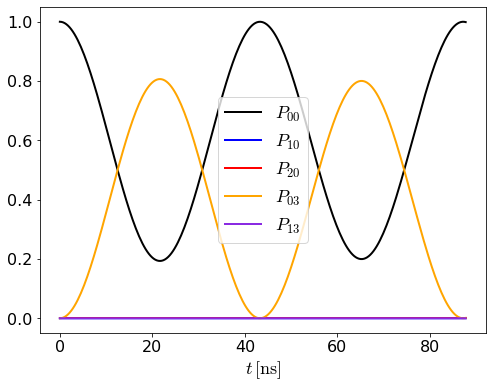

In [350]:
def prob_plot(
    tlist: np.ndarray, 
    probs: dict, 
    opt: dict={'fs': 18, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 16}
) -> None:
    colors=['black', 'blue', 'red', 'orange', 'blueviolet']
    levels = list(probs.keys())
    n_levels = len(levels)
    fig, ax = plt.subplots(figsize=(8, 6))
    for lev, k in zip(levels, range(n_levels)):
        ax.plot(tlist, probs[lev], linewidth=opt['lw'], 
                color=colors[k], label='$P_{' + lev + '}$')
    ax.set_xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
    ax.tick_params(labelsize=opt['ls'])
    plt.legend(fontsize=opt['fs'])
    plt.show()
    
prob_plot(tlist_eval, probs)  

In [351]:
env_syst_dt = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, options=simu_opt)

In [352]:
n_process = 4

start = time.time()
sup_op_dt = env_syst_dt.to_super(comp_states, weyl_by_index, n_process)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 222.38974475860596 s


In [264]:
sq_corr_dt = util.single_qubit_corrections(sup_op_dt, weyl_by_index)
sq_corr_sup_dt = trf.kraus_to_super(sq_corr_dt, weyl_by_index)
total_sup_op_dt = sq_corr_sup_dt.dot(sup_op_dt)

In [265]:
x1 = np.kron(np.array([[0., 1.], [1., 0.]]), np.identity(2))
x1_super = trf.kraus_to_super(x1, weyl_by_index)
f_pro_x1 = average_process_fidelity(x1_super, total_sup_op_dt)
f_pro_cz = average_process_fidelity(cz_super, total_sup_op_dt)
f_pro_ide = average_process_fidelity(ide_super, total_sup_op_dt)
display(Latex(r'$F_{{pro, X1}} = {:.5f}$'.format(f_pro_x1)))
display(Latex(r'$F_{{pro, CZ}} = {:.5f}$'.format(f_pro_cz)))
display(Latex(r'$F_{{pro, I}} = {:.5f}$'.format(f_pro_ide)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [102]:
avg_leakage_dt = env_syst_dt.leakage(comp_states)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage_dt)))

<IPython.core.display.Latex object>

In [54]:
levels = ['00', '10', '20', '03', '13']
probs = {}
eval_step = 10
tlist_eval = tlist_stark[::eval_step]
for lev in levels:
    prob_list = []
    for k in range(len(tlist_eval)):
        state = coupled_sys_stark.state(lev, as_qobj=True)[1]
        prob_list.append(qutip.expect(state*state.dag(), output.states[k*eval_step]))
    probs[lev] = prob_list

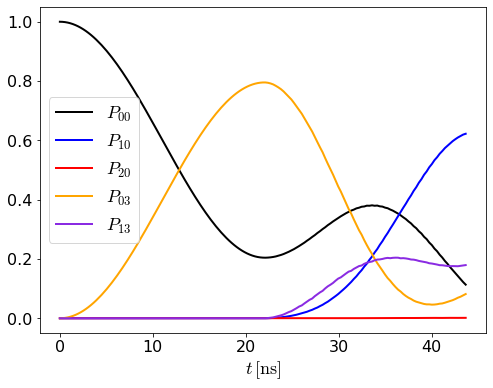

In [55]:
def prob_plot(
    tlist: np.ndarray, 
    probs: dict, 
    opt: dict={'fs': 18, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 16}
) -> None:
    colors=['black', 'blue', 'red', 'orange', 'blueviolet']
    levels = list(probs.keys())
    n_levels = len(levels)
    fig, ax = plt.subplots(figsize=(8, 6))
    for lev, k in zip(levels, range(n_levels)):
        ax.plot(tlist, probs[lev], linewidth=opt['lw'], 
                color=colors[k], label='$P_{' + lev + '}$')
    ax.set_xlabel('$t \, [\mathrm{ns}]$', fontsize=opt['fs'])
    ax.tick_params(labelsize=opt['ls'])
    plt.legend(fontsize=opt['fs'])
    plt.show()
    
prob_plot(tlist_eval, probs)  

We introduce the tomography environment for the new AC-Stark driven system

In [58]:
def infidelity_func(
    x0: np.ndarray,
    system: QubitSystem,
    times: np.ndarray,
    **kwargs
) -> float:
    state_labels = ['00', '01', '10', '11']
    comp_states = []
    for label in state_labels:
        comp_states.append(system.state(label)[1])
    t_gate = times[-1]
    system['T_stark'].drives['stark_drive_t'].set_params(phase=0.0, time=times, rise_time=0.0,
                                                         pulse_time=t_gate, amp=x0[0], freq=x0[1])
    system['F_stark'].drives['cz_drive_f'].set_params(phase=0, time=times, rise_time=0.0, pulse_time=t_gate,
                                                            amp=x0[2], freq=x0[3])
    
    env = pysqkit.tomography.TomoEnv(system=system, time=2*np.pi*times, options=simu_opt)
    
    n_process = 4

    sup_op = env.to_super(comp_states, weyl_by_index, n_process)
    
    sq_corr = util.single_qubit_corrections(sup_op, weyl_by_index)
    sq_corr_sup = trf.kraus_to_super(sq_corr, weyl_by_index)
    total_sup_op = sq_corr_sup.dot(sup_op)
    
    ide = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    ide_super = trf.kraus_to_super(ide, weyl_by_index)
    
    return 1 - average_process_fidelity(ide_super, total_sup_op)

start = time.time()

infid = infidelity_func(np.array([0.0, 0.0]), coupled_sys_stark, tlist_stark)

end = time.time()

print("Computation time = {} s".format(end - start))

print("Fidelity = {}".format(1 - infid))

Computation time = 88.60693001747131 s
Fidelity = 0.24994869172570788


In [68]:
##Print callback function
def printx(Xi):
    global Nfeval
    print('At iterate {0:4d},  f={1: 3.6f} '.format(Nfeval, infidelity_func(Xi, 
                                                                            coupled_sys_stark, tlist_stark)) + '\n')
    Nfeval += 1

x0_fid = np.array([0.02, 4.55]) #initial guess
args_to_pass = (coupled_sys_stark, tlist_stark) 

start = time.time()

Nfeval = 1

minimization_fid_result = minimize(infidelity_func, x0_fid, args=args_to_pass, method='COBYLA', 
                                   callback=printx, options={'disp': True, 'maxiter': 10} )

end = time.time()

display(Latex(r'$\mathrm{{Fidelity minimization \, time}} = {:.3f} \, s$'.format(end - start)))

<IPython.core.display.Latex object>


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   10   F = 7.500792E-01    MAXCV = 0.000000E+00
   X = 2.000000E-02   5.550000E+00


In [69]:
minimization_fid_result

     fun: 0.750079212129186
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 10
  status: 2
 success: False
       x: array([0.02, 5.55])

In [35]:
env_syst_stark = pysqkit.tomography.TomoEnv(system=coupled_sys_stark, time=2*np.pi*tlist_stark, options=simu_opt)

and obtain the new superoperator

In [37]:
n_process = 4

start = time.time()
sup_op_stark = env_syst_stark.to_super(comp_states, weyl_by_index, n_process)
end = time.time()
print("Computational time = " + str(end - start) + ' s')

Computational time = 119.99062418937683 s


we obtain the single-qubit corrections

In [38]:
sq_corr_stark = util.single_qubit_corrections(sup_op_stark, weyl_by_index)
sq_corr_sup_stark = trf.kraus_to_super(sq_corr_stark, weyl_by_index)
total_sup_op_stark = sq_corr_sup_stark.dot(sup_op_stark)

We want the quantum operation to be the identity in this case

In [39]:
ide = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
ide_super = trf.kraus_to_super(ide, weyl_by_index)

The process fidelity with the AC-Stark drive is

In [41]:
f_pro_stark_ide = average_process_fidelity(ide_super, total_sup_op_stark)
#f_pro_stark_cz = average_process_fidelity(cz_super, total_sup_op_stark)
display(Latex(r'$F_{{pro, I}} = {:.5f}$'.format(f_pro_stark_ide)))
#display(Latex(r'$F_{{pro, CZ}} = {:.5f}$'.format(f_pro_stark_cz)))

<IPython.core.display.Latex object>

In [51]:
avg_leakage_stark = env_syst_stark.leakage(comp_states)
display(Latex(r'$L_1(\mathcal{{E}} ) = {:.7f}$'.format(avg_leakage_stark)))

<IPython.core.display.Latex object>

Now it seems that the main issue is leakage in this case, but leakage from where?

# Leakage analysis with AC-Stark drive

In [58]:
def run(
    time: np.ndarray,
    system: QubitSystem, 
    state_init:qtp.qobj.Qobj, 
    options: qtp.solver.Options=None
):
    hamil0 = system.hamiltonian(as_qobj=True)
    hamil_drive = []
    pulse_drive = []
                    
    for qubit in system:
        if qubit.is_driven:
            for label, drive in qubit.drives.items():
                hamil_drive.append(drive.hamiltonian(as_qobj=True))
                pulse_drive.append(drive.eval_pulse())
    jump_op = [op for qubit in system for op in qubit.collapse_ops(as_qobj=True)]
                    
    result = integrate(time, state_init, hamil0, hamil_drive,
                           pulse_drive, jump_op , "mesolve", options=options)
                    
    return result  

In [67]:
start = time.time()

_proj_comp = np.einsum('ai, aj -> ij', comp_states, np.conj(comp_states))
subsys_dims = list(q.dim_hilbert for q in coupled_sys_stark)
proj_comp = qtp.Qobj(inpt=_proj_comp, dims=[subsys_dims, subsys_dims], isherm=True)
res = run(time=2*np.pi*tlist_stark, system=coupled_sys_stark, state_init=proj_comp/d_comp, options=simu_opt)

end=time.time()
display(Latex(r'$\mathrm{{Leakage \, computation \, time}} = {:.3f} \, s$'.format(end - start)))
l1 = 1 - qtp.expect(proj_comp, res.states[-1])

<IPython.core.display.Latex object>

In [68]:
leakage_states = ['13', '03', '04', '12', '20']

In [69]:
def get_probabilities(
    states_label: List[str], 
    system:QubitSystem, 
    final_state: qtp.qobj.Qobj
) -> Dict:
    prob = {}
    for label in states_label:
        ket = system.state(label, as_qobj=True)[1]
        projector = ket*ket.dag()
        prob[label] = qtp.expect(projector, final_state)
    return prob

In [70]:
leak_probs = get_probabilities(leakage_states, coupled_sys, res.states[-1])

display(Latex(r'$\mathrm{{Average\, Leakage \,}} L_1 = {:.7f} $'.format(l1)))

sum_leak = 0

for label in leakage_states:
    display(Latex(r'$P_{{leak, {}  }} = {:.7f}$'.format(label, leak_probs[label])))
    sum_leak += leak_probs[label]
display(Latex(r'$\sum_k P_{{leak, k  }} = {:.7f}$'.format(sum_leak)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [157]:
transm_stark.drives["stark_drive_t"].eval_pulse()

array([ 0.2       , -0.02957124, -0.19125542,  0.08612785,  0.16578634,
       -0.13515293, -0.12581994,  0.17235945,  0.0748511 , -0.19449385,
       -0.01733685,  0.19962058, -0.04169343, -0.18729131,  0.0970778 ,
        0.1585842 , -0.14397312, -0.11600955,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.  

In [233]:
rabi_period_stark

44.66266358594102

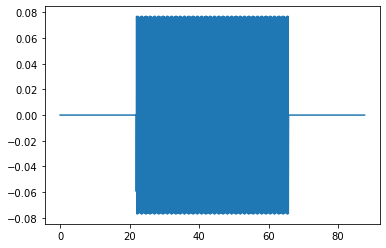

In [275]:
plt.plot(tlist, transm.drives["transm_drive"].eval_pulse())

In [46]:
transm_stark = pysqkit.qubits.SimpleTransmon(
    label='T_stark', 
    max_freq=4.5, 
    anharm=-0.3,
    diel_loss_tan=0.75*1e-6, #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t,
    dephasing_times = {'1': 2*np.pi*50*1e3, '2': 2*np.pi*30*1e3} 
)

transm_stark.add_drive(
    pysqkit.drives.microwave_drive,
    label='stark_drive_t',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

flx_stark = pysqkit.qubits.Fluxonium(
    label='F_stark', 
    charge_energy=.973, 
    induct_energy=.457, 
    joseph_energy=8.0, 
    diel_loss_tan=7.1*1e-6, #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,
    dephasing_times = {'1': 2*np.pi*200*1e3, '2':2*np.pi*20*1e3, 
                       '3': 2*np.pi*20*1e3, '4': 2*np.pi*5*1e3} #ns/2*np.pi 
)
flx_stark.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx_stark.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)


coupled_sys_stark = transm_stark.couple_to(flx_stark, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)

In [47]:
x0_stark = np.array([0.03, 4.4]) #initial guess
eps_ratios = {'T': 1.0, 'F':0.0}
args_to_pass = (['00', '10'], ['03', '13'], coupled_sys, eps_ratios) 

start = time.time()

minimization_result_stark = minimize(func_to_minimize, x0_stark, args=args_to_pass)

end = time.time()

display(Latex(r'$\mathrm{{Minimization \, time}} = {:.3f} \, s$'.format(end - start)))

<IPython.core.display.Latex object>

We set the parameters of the AC-Stark drive

In [52]:
eps_stark = minimization_result_stark['x'][0] # GHz
freq_stark = minimization_result_stark['x'][1]
big_omega_stark = eps_stark*transm_stark.charge_zpf/2
rabi_period_stark = rabi_period
t_simu = rabi_period_stark
nb_points_stark = int(t_simu*freq_drive*pts_per_drive_period)
tlist_stark = np.linspace(0, t_simu, nb_points_stark)
coupled_sys_stark['T_stark'].drives['stark_drive_t'].set_params(phase=0.0, time=tlist_stark, rise_time=0.0,
                                                                pulse_time=rabi_period_stark, start_time=rabi_period_stark/2,
                                                                amp=eps_stark, freq=freq_stark)
coupled_sys_stark['F_stark'].drives['cz_drive_f'].set_params(phase=0, time=tlist_stark, rise_time=t_rise, pulse_time=t_simu,
                                                             amp=eps_drive, freq=freq_drive)


Before running the tomography we check that the transmon drive works as expected

In [53]:
# Setting up simulation
hamil0 = coupled_sys_stark.hamiltonian(as_qobj=True)
hamil_drive = [coupled_sys_stark['T_stark'].drives['stark_drive_t'].hamiltonian(as_qobj=True)]
hamil_drive.append(coupled_sys_stark['F_stark'].drives['cz_drive_f'].hamiltonian(as_qobj=True))
pulse_drive = [coupled_sys_stark['T_stark'].drives['stark_drive_t'].eval_pulse()]
pulse_drive.append(coupled_sys_stark['F_stark'].drives['cz_drive_f'].eval_pulse())
collapse_ops = [op for qubit in coupled_sys_stark for op in qubit.collapse_ops(as_qobj=True)]
dephasing_ops = [qubit.dephasing_op(as_qobj=True) for qubit in coupled_sys_stark]
jump_ops = collapse_ops + dephasing_ops
state_in = coupled_sys_stark.state('00', as_qobj=True)[1]
tlist_prova = np.linspace(0, rabi_period_stark, nb_points)

output = solvkit.integrate(2*np.pi*tlist_stark, state_in, hamil0, hamil_drive, pulse_drive, jump_ops, "mesolve", options=simu_opt) 

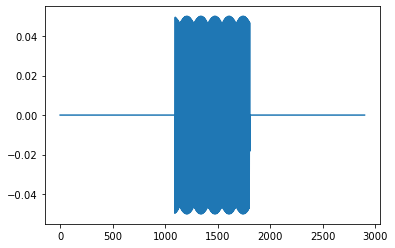

In [64]:
plt.plot(transm.drives["transm_drive"].eval_pulse())

In [17]:
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])

In [20]:
xx = np.kron(x, x)
yy = np.kron(y, y)
zz = np.kron(z, z)

In [25]:
np.linalg.eig(xx + yy + zz)[0]

array([ 1.+0.j, -3.+0.j,  1.+0.j,  1.+0.j])

In [48]:
t_simu

43.8153377195107

In [49]:
tlist_stark[-1]

43.8153377195107

In [79]:
pippo = []
pluto = []

In [80]:
pippo + pluto

[]

In [10]:
pippo = [None, None]

In [11]:
pippo

[None, None]